## Klasifikacija zrna pirinca

Jupiter sveska predstavlja moju metodologiju za rešavanje problema klasifikacije zrna pirinca. Prikazaću celekupan proces kao i način na koji je razvijan od prostog do složenog procesa koji je u stanju da tačno klasifikuje oko 90% zrna. 
Sveska je pokaznog karaktera jer je stastavljena od različitih delova koji nisu pokretani u isto vreme.

### Ucitavanje biblioteka

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import time 

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Definisanje konstanti 

In [ ]:
IMAGE_WIDTH=96
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
reference_shape = [IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS]
shape_str = '_'.join([str(i)for i in reference_shape[:2]])
batch_size = 8
num_classes = 90

Prvobitno sam odredio da referenten dimenzije slike budu (70,186) što je bio minimum po obe ose. Takodje ovaj odnos je bio približan odnosu većine drugih slike. Medjutim, većina dostupnih prepodešenih modela rade najbolje sa dimenzijama koje su umošci broja osam npr. 96,224,512...

### Učitavanje podataka

Podaci se nalaze u dva folder: train i test. Medjutim, nama treba i validacioni set koji ćemo koristiti da izabermo najpreciznije modele, podesimo paramere i sprečimo overfitovanje. Stoga treba da kreiramo novi folder za validacione set i tamo prebacimo odgovarajuće podatke iz train foldera. Kada kažem odgovarajuće podatke aludiram na to da moramo podeliti podatke tako da se distribucija slika sa različitim klasama u oba modela ista. 

In [2]:
base_dir =os.getcwd()
models_dir = 'models'
model_files = os.listdir(models_dir)

In [ ]:
# Deljnje podataka na trening i validacione
# Dele se samo putanje do foldera pa se pomocu njih podaci premestaju iz jednog foldera u drugi 
labels = pd.read_csv(os.path.join(base_dir,'train.csv'))
X,y = labels.iloc[:,0],labels.iloc[:,1]
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.25,stratify = y,random_state=42)

In [ ]:
# Smestanja slika u novi folder za validaciju
X_valid = list(X_valid)
os.mkdir("validation")
source = os.path.join(base_dir,'train')
target = os.path.join(base_dir,'validation')

#Prebacivanje podataka
for path in file_list:
  label = int(path.split('.')[0])
  if label in X_valid:
    os.rename(os.path.join(source,path),os.path.join(target,path))

Ucitavamo podatke u generator. Prednost sa njima je to sto ne skladiste podatke u memoriji vec ih generisu u toku obrade. To nam omogucava da radimo sa ogromnim kolicinama koje inace ne bi mogle da stanu u radnu memoriju. 
Uz to definisemo i korake za augmentaciju podataka. Augmentacija treba da bude odradjena tako da covek ne bimogao da primeti da li je slika augmentovana ili nije tj. da se zadrze neke intrinzicne karakteristike slike. Posto se na slika zrna pirinca nalaze u sredini i samo zrno je simetricno, mi mozemo da obrnemo slike po horizontali i vertikali i dobijemo dodatne slike. Takodje mozemo da transliramo sliku po horizontali i vertikali ali u nekom malom opsegu

In [4]:
labels = pd.read_csv(os.path.join(base_dir,'train.csv'),index_col=0)

train_filenames = os.listdir(os.path.join(base_dir,'train'))
train_classes = []
for filename in train_filenames:
  label = int(filename.split('.')[0])
  klasa = str(labels.loc[label].iloc[0])
  train_classes.append(klasa)

train_df = pd.DataFrame({'ID':train_filenames,'ClassID':train_classes})
train_datagen = ImageDataGenerator(
    vertical_flip=True,
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    os.path.join(base_dir,'train'),
    x_col='ID',
    y_col='ClassID',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5508 validated image filenames belonging to 90 classes.


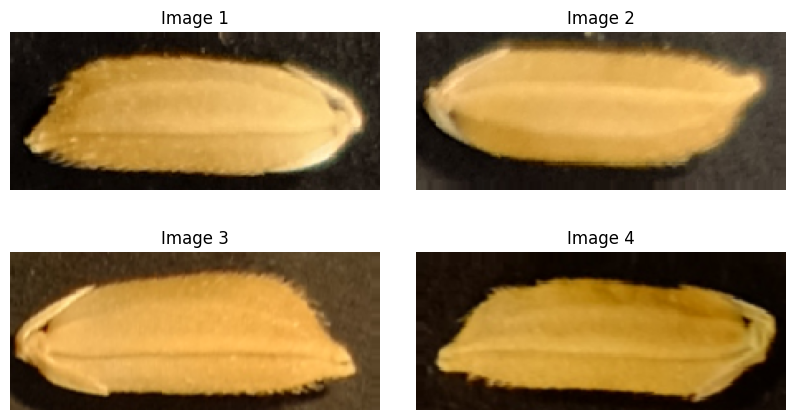

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=-0.6,wspace=0.1) 

axes[0, 0].imshow(next(train_generator)[0][0])
axes[0, 0].set_title('Image 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(next(train_generator)[0][1])
axes[0, 1].set_title('Image 2')
axes[0, 1].axis('off')

axes[1, 0].imshow(next(train_generator)[0][2])
axes[1, 0].set_title('Image 3')
axes[1, 0].axis('off')

axes[1, 1].imshow(next(train_generator)[0][3])
axes[1, 1].set_title('Image 4')
axes[1, 1].axis('off')

plt.show()


In [5]:

valid_ID = os.listdir(os.path.join(base_dir,'validation'))
valid_classes = []
for filename in valid_ID:
    label = int(filename.split('.')[0])
    klasa = str(labels.loc[label].iloc[0])
    valid_classes.append(klasa)

valid_df = pd.DataFrame({'ID':valid_ID,'ClassID':valid_classes})

### Definisanje modela

In [ ]:
# Definisemo model od samog pocetka
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 222, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 111, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 109, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 26, 128)       

In [ ]:
# Definisanje funkcije koja automatski cuva najbolji model. Imenujem modele na osnovu vremena kada sam ga kreirao da bi znao posle koji koliko dobro radi
c_time = time.strftime("%d_%m_%H_%M", time.localtime())
checkpoint = ModelCheckpoint(f'models/nat_{shape_str}_{c_time}.h5')
# Definisanje ranog zaustavljanja. Kao posledicu ove funkcije mozemo da definisemo veliki broj eopha a treniranje ce se zaustaviti kada prestanemo da ostvarujemo napredak
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

# Redukcija stope ucenja kada se validaciona preciznost ne poboljsa. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction,checkpoint]

In [ ]:
history = model.fit(train_generator,validation_data = validation_generator, epochs = 50,batch_size=batch_size,callbacks = callbacks)

Epoch 1/50


368/368 [==============================] - 151s 395ms/step - loss: 4.5158 - accuracy: 0.0080 - val_loss: 4.4851 - val_accuracy: 0.0109 - lr: 0.0010
Epoch 2/50
368/368 [==============================] - 148s 402ms/step - loss: 4.3698 - accuracy: 0.0187 - val_loss: 4.2283 - val_accuracy: 0.0316 - lr: 0.0010
Epoch 3/50
368/368 [==============================] - 163s 441ms/step - loss: 4.1685 - accuracy: 0.0359 - val_loss: 4.0251 - val_accuracy: 0.0507 - lr: 0.0010
Epoch 4/50
368/368 [==============================] - 143s 388ms/step - loss: 3.9185 - accuracy: 0.0601 - val_loss: 3.5332 - val_accuracy: 0.1062 - lr: 0.0010
Epoch 5/50
368/368 [==============================] - 175s 476ms/step - loss: 3.4276 - accuracy: 0.1285 - val_loss: 3.0959 - val_accuracy: 0.1803 - lr: 0.0010
Epoch 6/50
368/368 [==============================] - 173s 469ms/step - loss: 3.0301 - accuracy: 0.1832 - val_loss: 2.7597 - val_accuracy: 0.2347 - lr: 0.0010
Epoch 7/50
368/368 [========================

Model koji smo sami definisali nam je overfitovao medjutim dao je dobre konacne rezultate spram referentnih metrika i trazenih rezultate. Mozemo dodamo jos regularizacije u model ali bolje bi resenje bilo da probamo da iskoristimo vec istrenirane modele kao potporu za nas model tj. da primenimo takozvani transfer znanja 

In [ ]:
# Ucitavanje vec istreniranog modela koji sluzi kao potpora. Ne ukljucujemo rep modela zato sto cemo njega sami definisati
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

# Zamrzavanje slojeva u modelu da ne bi doslo do unistavanja modifikovanih tezina na samom pocetku
for layer in base_model.layers:
    layer.trainable = False

# Definisanje repa modela
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.30),
    layers.Dense(num_classes, activation='softmax')  # 
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
checkpoint = ModelCheckpoint(f'models/mobile_net_{shape_str}_{c_time}.h5')
callbacks = [earlystop, learning_rate_reduction,checkpoint]

In [ ]:
model.fit(train_generator,validation_data = validation_generator,epochs = 10, callbacks = callbacks,workers=16)

Epoch 1/10


689/689 [==============================] - 60s 85ms/step - loss: 4.2184 - accuracy: 0.0508 - val_loss: 3.6940 - val_accuracy: 0.1002 - lr: 0.0010
Epoch 2/10


c:\Users\ilija\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 [==============================] - 52s 76ms/step - loss: 3.5542 - accuracy: 0.1109 - val_loss: 3.1518 - val_accuracy: 0.1950 - lr: 0.0010
Epoch 3/10
689/689 [==============================] - 57s 83ms/step - loss: 3.2330 - accuracy: 0.1572 - val_loss: 2.9361 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 4/10
689/689 [==============================] - 56s 81ms/step - loss: 3.0618 - accuracy: 0.1843 - val_loss: 2.8198 - val_accuracy: 0.2560 - lr: 0.0010
Epoch 5/10
689/689 [==============================] - 58s 84ms/step - loss: 2.9648 - accuracy: 0.2106 - val_loss: 2.7211 - val_accuracy: 0.2751 - lr: 0.0010
Epoch 6/10
689/689 [==============================] - 56s 82ms/step - loss: 2.8835 - accuracy: 0.2231 - val_loss: 2.6400 - val_accuracy: 0.2761 - lr: 0.0010
Epoch 7/10
689/689 [==============================] - 57s 82ms/step - loss: 2.8201 - accuracy: 0.2289 - val_loss: 2.6055 - val_accuracy: 0.2985 - lr: 0.0010
Epoch 8/10
689/689 [==============================] - 57s 82ms/step -

In [ ]:
# Nakon inicijalnog treniga odmrzavamo slojeve i treniramo model iz pocetka 
base_model.trainable = True

# Potrebno je da opet kompajliramo model. Treba staviti manju stopu ucenja kako bi sacuvali naucene tezine
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_generator,validation_data = validation_generator,epochs = 70, callbacks = callbacks,workers=4)

Epoch 1/70
689/689 [==============================] - 396s 436ms/step - loss: 3.6505 - accuracy: 0.1064 - val_loss: 6.9698 - val_accuracy: 0.0463 - lr: 1.0000e-04
Epoch 2/70
689/689 [==============================] - 295s 428ms/step - loss: 3.1962 - accuracy: 0.1594 - val_loss: 3.7295 - val_accuracy: 0.1231 - lr: 1.0000e-04
Epoch 3/70
689/689 [==============================] - 307s 445ms/step - loss: 2.9889 - accuracy: 0.1934 - val_loss: 3.5658 - val_accuracy: 0.1754 - lr: 1.0000e-04
Epoch 4/70
689/689 [==============================] - 312s 452ms/step - loss: 2.8234 - accuracy: 0.2253 - val_loss: 4.2393 - val_accuracy: 0.1536 - lr: 1.0000e-04
Epoch 5/70
689/689 [==============================] - 295s 428ms/step - loss: 2.6736 - accuracy: 0.2565 - val_loss: 3.0956 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 6/70
689/689 [==============================] - 298s 432ms/step - loss: 2.5189 - accuracy: 0.2994 - val_loss: 2.3853 - val_accuracy: 0.3328 - lr: 1.0000e-04
Epoch 7/70
689/689 [==

In [ ]:
# Ucitavanje test podataka. Tu nemamo y kolonu
test_filenames = os.listdir(os.path.join(base_dir,'test'))
test_df = pd.DataFrame({
    'ID': test_filenames
})


test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    os.path.join(base_dir,'test'),
    x_col='ID',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)
test_df['ID'] = test_df['ID'].apply(lambda x: int(x.split('.')[0]))

Found 1296 validated image filenames.


In [ ]:
predict = model.predict(test_generator)

162/162 [==============================] - 11s 58ms/step


In [ ]:
test_df['ClassID'] = np.argmax(predict, axis=-1)

In [ ]:
# train generator ima svoj nacin na koji vidi klase i na koji klasifikuje
# Da bi ga uskadili sa originialnim klasama neophodno je mapiramo kalse generatora u kalse koje su definisane u zadatku
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['ClassID'] = test_df['ClassID'].replace(label_map)

In [ ]:
# Cuvanje modela i predikacija
test_df.to_csv(f'submissions/mobile_net_{shape_str}_{c_time}.csv',index=False)
model.save(f'models/mobile_net_{shape_str}_{c_time}.h5')
model.save(f'models/mobile_net_{shape_str}_{c_time}.keras')

c:\Users\ilija\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Agregiranje modela

Koliko god da su modeli efikasni pojedinacno, komitet koji je sadrzan od modela slicne preciznosti ce odraditi bolji posao. Mi mozemo da kombinujemo predikcije razlicitih modela. Moze se reci da svaki model posmatra sliku iz drugacijeg ugla te kombinovanje tih drugacijih perspektiva moze biti korisno. Uopsteno, mudrost masa moze biti korisna. Najefektivnija pomoc u Kvizu Milioner je pomoc publike. 

In [ ]:
# Ucitavanje najuspesnijih modela 
candidates = ['mobile_net_96_224_28_02_08_45.h5','mobile_net_96_224_28_02_19_08.h5','mobile_net_96_224_28_02_13_20.h5','mobile_net_96_224_29_02_12_39.h5']
models = {}

for candidate_file in candidates:
    candidate_text = candidate_file.split('.')[0]
    models[candidate_text] = tf.keras.models.load_model(os.path.join(models_dir,candidate_file))

In [ ]:
val_predictions = []
for text,model in models.items():
    val_predictions.append(model.predict(val_generator))
val_predictions = np.array(val_predictions)

230/230 [==============================] - 14s 57ms/step


In [ ]:
from sklearn.metrics import accuracy_score,f1_score
# Poredjenje rada pojedinacnih modela i ensebmle modela
f1_scores = []
for i,model in enumerate(models):
    print('Current model',model,'Number',i)
    valid_df['category'] = np.argmax(val_predictions[i], axis=-1)
    label_map = dict((v,k) for k,v in train_generator.class_indices.items())
    valid_df['category'] = valid_df['category'].replace(label_map)


    print('Accuracy is:',accuracy_score(valid_df['ClassID'],valid_df['category']))
    print('F1 score',f1_score(valid_df['ClassID'],valid_df['category'],average='macro'))
    print('\n')
    f1_scores.append(f1_score(valid_df['ClassID'],valid_df['category'],average='macro'))

print('Ensemble model')
valid_df['category'] = np.argmax(val_predictions.mean(axis=0), axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
valid_df['category'] = valid_df['category'].replace(label_map)

print('Accuracy of the ensebmle model is')
print('Accuracy is:',accuracy_score(valid_df['ClassID'],valid_df['category']))
print('F1 score',f1_score(valid_df['ClassID'],valid_df['category'],average='macro'))
print('\n')



Current model mobile_net_96_224_28_02_08_45 Number 0
Accuracy is: 0.8202614379084967
F1 score 0.8199829668177568


Current model mobile_net_96_224_28_02_19_08 Number 1
Accuracy is: 0.8442265795206971
F1 score 0.8439328379346913


Current model mobile_net_96_224_28_02_13_20 Number 2
Accuracy is: 0.8235294117647058
F1 score 0.8216043533772311


Current model mobile_net_96_224_29_02_12_39 Number 3
Accuracy is: 0.8600217864923747
F1 score 0.8592468570258488


Ensemble model
Accuracy of the ensebmle model is
Accuracy is: 0.8741830065359477
F1 score 0.8728671586849944




In [ ]:
predictions = []

for model in models.values():
    predictions.append(model.predict(test_generator))
predictions = np.array(predictions)

162/162 [==============================] - 10s 59ms/step


In [ ]:
test_df['ClassID'] = np.argmax(predictions.mean(axis=0), axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['ClassID'] = test_df['ClassID'].replace(label_map)

Ensemble model


In [ ]:
import time
c_time = time.strftime("%d_%m_%H_%M", time.localtime())

test_df.to_csv(f'submissions/mixed_ensemble_{c_time}.csv',index=False)


#### Koriscenje evolutivnih algoritama da pronadjemo najbolju kominaciju

In [ ]:
from scipy.optimize import differential_evolution


# Funkcija za predikcije
def ensemble_predictions(predictions,weights,label_map):
    # Sumiranje podataka na osnovu njihovih tezina
    summed = np.tensordot(predictions,weights,axes=((0),(0))).argmax(axis=1)
    return pd.Series(summed).replace(label_map)


def normalize(weights):
    # calculate l1 vector norm
    result = np.linalg.norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

def evaluate_ensemble(predictions,weights,label_map,y_test):
      return accuracy_score(ensemble_predictions(predictions,weights,label_map),y_test)

# Definisanje funkcije gubitka za evolutivni algoritam
def loss_function(weights,predictions,label_map,y_test):
    weights = normalize(weights)
    # funckija gubitka je 1 - preciznost. To pokusavamo da minimizujemo
    return 1 - evaluate_ensemble(predictions,weights,label_map,y_test)




In [ ]:
y_test = valid_df['ClassID']
# Definisanje granica za parametre w
bound_w = [(0.0, 1.0)  for _ in range(len(candidates))]
# Definisanje vrednosti koje su konstantne - predikcije i ground truth podatke
search_arg = (val_predictions, label_map, y_test)
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=150, tol=1e-7)


In [ ]:
weights = normalize(result['x'])

In [ ]:
y_test = valid_df['ClassID']
evaluate_ensemble(val_predictions,weights,label_map,y_test)

0.8818082788671024

In [ ]:
test_df['ClassID'] = ensemble_predictions(predictions,weights,label_map)

In [62]:
c_time = time.strftime("%d_%m_%H_%M", time.localtime())

test_df.to_csv(f'submissions/evolutionary_ensemble_{c_time}.csv',index=False)